# Loan Prediction Practice Problem
A Data Visualization & Machine Learning Practice, dataset is from **Analytics Vidhya** ([link](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/#About))
<br>
<br>
***Objective: Predict Loan Eligibility for Dream Housing Finance company***

Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are **Gender**, **Marital Status**, **Education**, **Number of Dependents**, **Income**, **Loan Amount**, **Credit History** and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 
<br>
<br>
***Column Description***

* *Loan_ID* -	Unique Loan ID
* *Gender* -	Male/ Female
* *Married* -	Applicant married (Y/N)
* *Dependents* -	Number of dependents
* *Education* -	Applicant Education (Graduate/ Under Graduate)
* *Self_Employed* -	Self employed (Y/N)
* *ApplicantIncome* -	Applicant income
* *CoapplicantIncome* -	Coapplicant income
* *LoanAmount* -	Loan amount in thousands
* *Loan_Amount_Term* -	Term of loan in months
* *Credit_History* -	credit history meets guidelines
* *Property_Area* -	Urban/ Semi Urban/ Rural
* *Loan_Status* -	(Target) Loan approved (Y/N)

In [1]:
# Set up
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline

train = pd.read_csv('./data/train.csv')
print(train.shape)
train.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [2]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [3]:
# Collecting the 'object' columns
obj_cols = list(train.columns[train.dtypes=='object'])
obj_cols.remove('Loan_ID')
obj_cols

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [4]:
# Showing unique values of each column with 'object' data types
# This will help determine how to preprocess them into number data types
for col in obj_cols:
    print(f"{col}:")
    print(f"{train[col].unique()}\n")

Gender:
['Male' 'Female' nan]

Married:
['No' 'Yes' nan]

Dependents:
['0' '1' '2' '3+' nan]

Education:
['Graduate' 'Not Graduate']

Self_Employed:
['No' 'Yes' nan]

Property_Area:
['Urban' 'Rural' 'Semiurban']

Loan_Status:
['Y' 'N']



# Preprocessing Data

In [5]:
ntrain = train.copy()

## Finding missing values

In [6]:
rows = train.shape[0]

for col in ntrain.columns:
    missing = ntrain[col].isnull().sum()
    if missing > 0:
        print(f"{col}: {(missing/rows)*100:.2f}%")
        print(f"{missing} missing values out of {rows}\n")

Gender: 2.12%
13 missing values out of 614

Married: 0.49%
3 missing values out of 614

Dependents: 2.44%
15 missing values out of 614

Self_Employed: 5.21%
32 missing values out of 614

LoanAmount: 3.58%
22 missing values out of 614

Loan_Amount_Term: 2.28%
14 missing values out of 614

Credit_History: 8.14%
50 missing values out of 614



Luckily, none of the columns above have significantly large amounts of missing data, so I will simply determine the missing values myself based on similar patterns. The first step that comes to mind is starting with the personal information data of the applicants, like gender, marriage status, number of dependents, employment type, and credit history.

### Gender

In [7]:
ntrain[ntrain.Gender.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
126,LP001448,NaN,Yes,3+,Graduate,No,23803,0.0,370.0,360.0,1.0,Rural,Y
171,LP001585,NaN,Yes,3+,Graduate,No,51763,0.0,700.0,300.0,1.0,Urban,Y
188,LP001644,NaN,Yes,0,Graduate,Yes,674,5296.0,168.0,360.0,1.0,Rural,Y
314,LP002024,NaN,Yes,0,Graduate,No,2473,1843.0,159.0,360.0,1.0,Rural,N
334,LP002103,NaN,Yes,1,Graduate,Yes,9833,1833.0,182.0,180.0,1.0,Urban,Y
460,LP002478,NaN,Yes,0,Graduate,Yes,2083,4083.0,160.0,360.0,NaN,Semiurban,Y
467,LP002501,NaN,Yes,0,Graduate,No,16692,0.0,110.0,360.0,1.0,Semiurban,Y
477,LP002530,NaN,Yes,2,Graduate,No,2873,1872.0,132.0,360.0,0.0,Semiurban,N
507,LP002625,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N


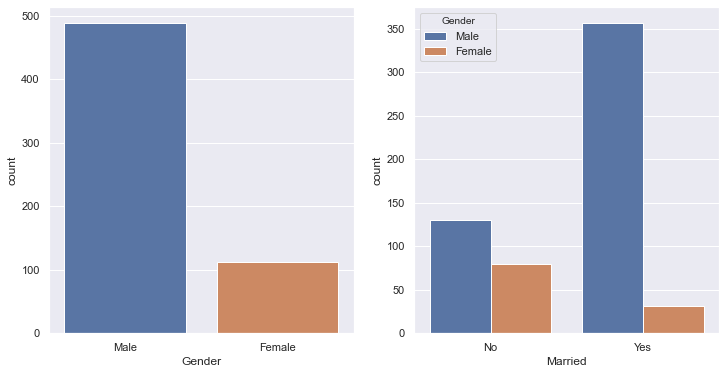

In [8]:
sns.set(rc={'figure.figsize': (12,6)})

# The 'Gender' column
subplot(1,2,1)
sns.countplot(data=ntrain, x='Gender')

# The 'Married' column
subplot(1,2,2)
sns.countplot(data=ntrain, x='Married', hue='Gender')

plt.show()

One thing I can infer from this is that a married applicant with a null gender value would most probably be male.

In [9]:
ntrain.loc[(ntrain.Gender.isnull()) & (ntrain.Married=='Yes'), "Gender"] = "Male"
ntrain.loc[(ntrain.Gender.isnull()) & (ntrain.Married=='Yes')]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


In [10]:
ntrain[ntrain.Gender.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
507,LP002625,NaN,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N
588,LP002925,NaN,No,0,Graduate,No,4750,0.0,94.0,360.0,1.0,Semiurban,Y
592,LP002933,NaN,No,3+,Graduate,Yes,9357,0.0,292.0,360.0,1.0,Semiurban,Y


All three applicants who still do not have a gender value are not married and have an education level of graduate (or above). Applicants no. 507 and no. 588 both have no dependents and are not self employed while applicant no. 592 has 3+ dependents, is self employed, and is a high income earner. Now I want to see which gender share similar patterns.

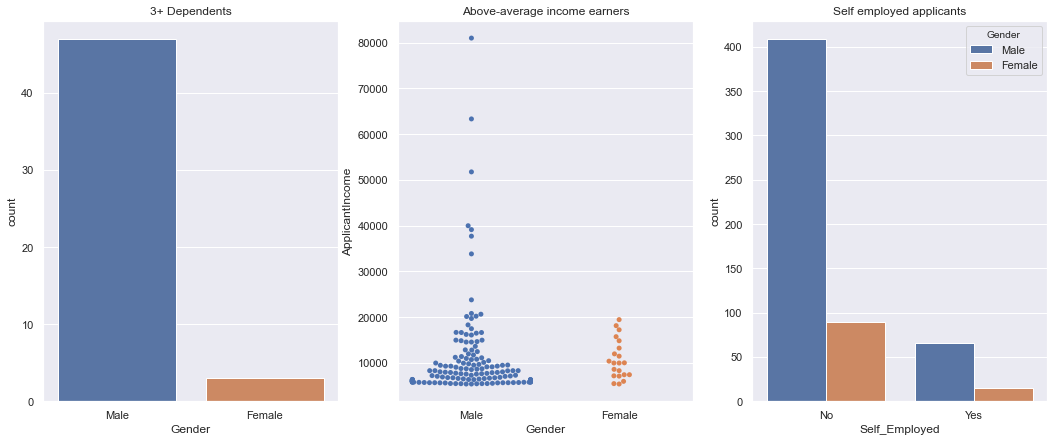

In [11]:
# Plotting cases for applicants who have 3+ dependents, are above-average income earners, and are self employed.

sns.set(rc={'figure.figsize': (18,7)})

subplot(1,3,1)
plt.title('3+ Dependents')
sns.countplot(data=ntrain[ntrain.Dependents=='3+'], x='Gender')

subplot(1,3,2)
plt.title('Above-average income earners')
sns.swarmplot(data=ntrain[ntrain.ApplicantIncome>ntrain.ApplicantIncome.mean()], x='Gender', y='ApplicantIncome')

subplot(1,3,3)
plt.title('Self employed applicants')
sns.countplot(data=ntrain, x='Self_Employed', hue='Gender')

plt.show()

So applicant no. 592 is, by probability, a male.

In [12]:
ntrain.loc[592,'Gender'] = 'Male'
ntrain.iloc[592, :]

Loan_ID               LP002933
Gender                    Male
Married                     No
Dependents                  3+
Education             Graduate
Self_Employed              Yes
ApplicantIncome           9357
CoapplicantIncome            0
LoanAmount                 292
Loan_Amount_Term           360
Credit_History               1
Property_Area        Semiurban
Loan_Status                  Y
Name: 592, dtype: object

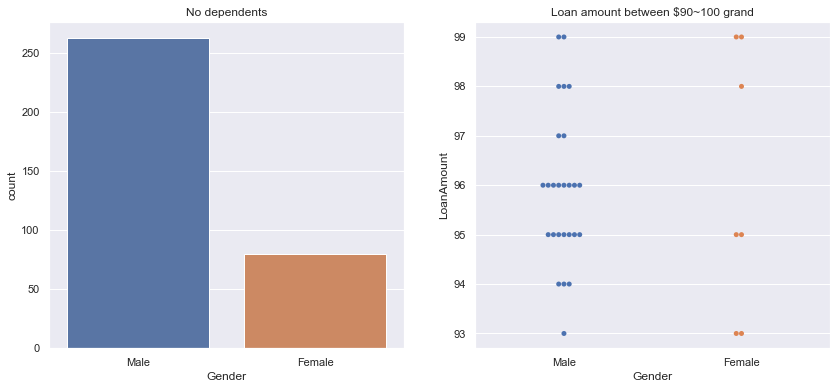

In [13]:
# Plotting cases for applicants with no dependents and applied for a loan amount of about $90~100 grand
sns.set(rc={'figure.figsize': (14,6)})

subplot(1,2,1)
plt.title('No dependents')
sns.countplot(data=ntrain[ntrain.Dependents=='0'], x='Gender')

subplot(1,2,2)
plt.title('Loan amount between $90~100 grand')
sns.swarmplot(data=ntrain[(ntrain.LoanAmount<100)&(ntrain.LoanAmount>90)], x='Gender', y='LoanAmount')

plt.show()

So... applicants no. 507 and no. 588 would also be male

In [14]:
ntrain.loc[[507,588],'Gender'] = 'Male'
ntrain.iloc[[507,588], :]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
507,LP002625,Male,No,0,Graduate,No,3583,0.0,96.0,360.0,1.0,Urban,N
588,LP002925,Male,No,0,Graduate,No,4750,0.0,94.0,360.0,1.0,Semiurban,Y


In [15]:
ntrain[ntrain.Gender.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Marriage Status

In [16]:
ntrain[ntrain.Married.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


Observations:
1. Applicants no.104 and no.228 are both male, have below-average income, and applied for approximately the same amount.
2. Applicant no.435 is female and has a well over average income

So I will see the marriage status of applicants with similar gender & income patterns

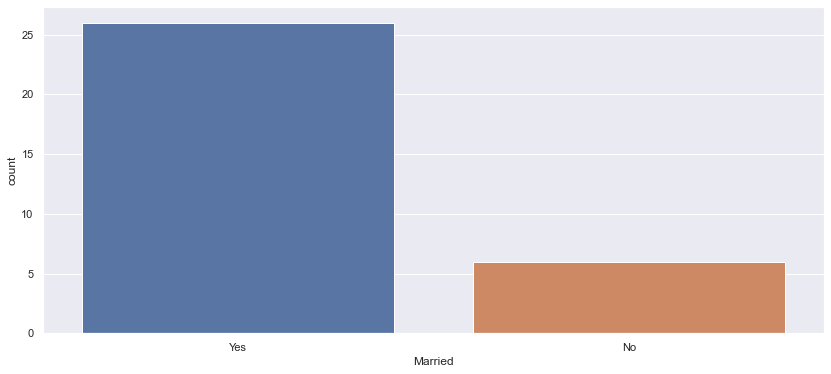

In [17]:
# Marriage status of male applicants with below-average income and who applied for a loan amount between $150~170 grand
# I'm supposing the loan amount and marriage status would have some sort of correlation...
filtered = ntrain[(ntrain.Gender=='Male')&(ntrain.ApplicantIncome<ntrain.ApplicantIncome.mean())&(ntrain.LoanAmount>150)&(ntrain.LoanAmount<170)]
sns.countplot(data=filtered, x='Married')

It seems fairly just to give applicants no.104 and no.228 a 'yes' value to their marriage status

In [18]:
ntrain.loc[[104,228],'Married'] = 'Yes'
ntrain.iloc[[104,228], :]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,Yes,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y


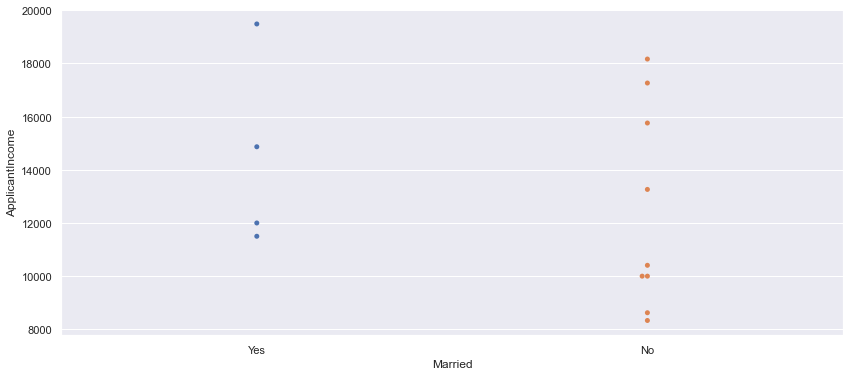

In [19]:
# Marriage status of high-income female applicants
sns.swarmplot(data=ntrain[(ntrain.Gender=='Female')&(ntrain.ApplicantIncome>8000)], x='Married', y='ApplicantIncome')

In [20]:
ntrain.loc[435, 'Married'] = 'No'
ntrain.iloc[435]

Loan_ID               LP002393
Gender                  Female
Married                     No
Dependents                 NaN
Education             Graduate
Self_Employed               No
ApplicantIncome          10047
CoapplicantIncome            0
LoanAmount                 NaN
Loan_Amount_Term           240
Credit_History               1
Property_Area        Semiurban
Loan_Status                  Y
Name: 435, dtype: object

In [21]:
ntrain[ntrain.Married.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Dependents

In [22]:
ntrain[ntrain.Dependents.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,Yes,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
293,LP001945,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
332,LP002100,Male,No,NaN,Graduate,No,2833,0.0,71.0,360.0,1.0,Urban,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N


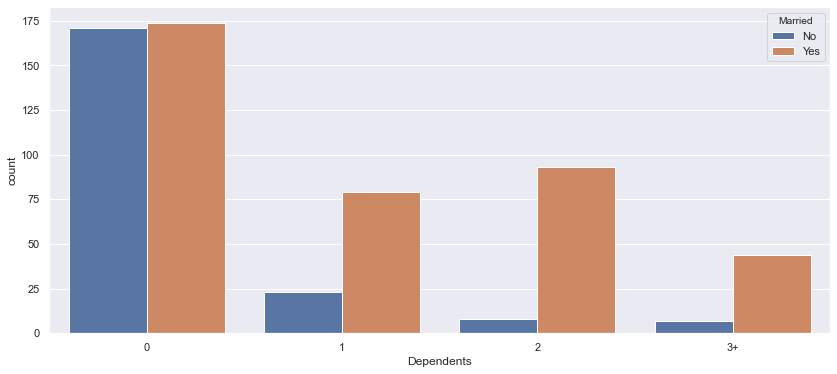

In [23]:
sns.countplot(data=ntrain, x='Dependents', hue='Married')

Some immediate findings can be that regardless of marriage status or education level of the applicant, the chances of them having any dependents is relatively small, especially is the applicant is not married. To me this seems like a safe indicator that it would be okay to replace all null values of 'Dependents' unmarried applicants to 0.

In [24]:
ntrain.loc[ntrain.Dependents.isnull() & (ntrain.Married=='No'), 'Dependents'] = '0'
ntrain[ntrain.Dependents.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
228,LP001760,Male,Yes,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N
517,LP002682,Male,Yes,NaN,Not Graduate,No,3074,1800.0,123.0,360.0,0.0,Semiurban,N
571,LP002847,Male,Yes,NaN,Graduate,No,5116,1451.0,165.0,360.0,0.0,Urban,N


Now, if the applicant is married, is there a definite pattern between the education level, income, loan amount of applicants and the number of dependents they have?

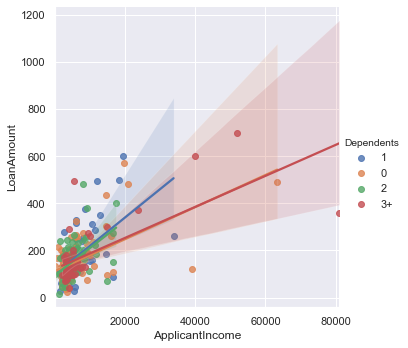

In [25]:
sns.lmplot(data=ntrain[ntrain.Married=='Yes'], x='ApplicantIncome', y='LoanAmount', hue='Dependents')

Since this graph is very hard to understand, I will divide the income groups so the definitions can be made clearer.

Average income: 5403.459283387622


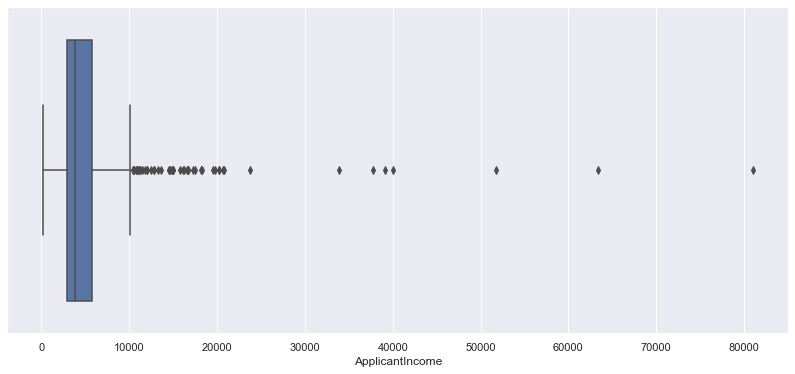

In [26]:
print(f"Average income: {ntrain.ApplicantIncome.mean()}")
sns.boxplot(data=ntrain, x='ApplicantIncome')

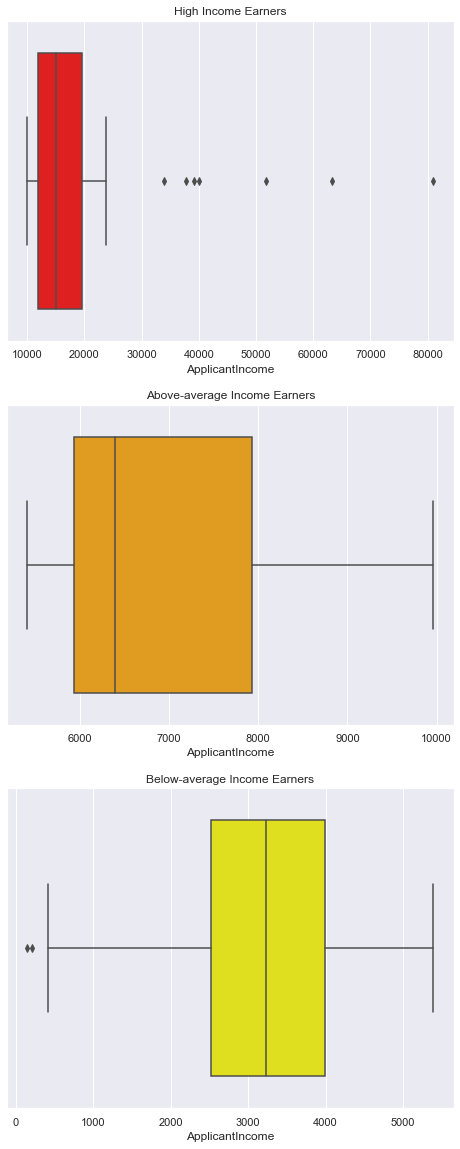

In [27]:
high_income = ntrain[ntrain.ApplicantIncome>10000]
above_average_income = ntrain[(ntrain.ApplicantIncome>ntrain.ApplicantIncome.mean())&(ntrain.ApplicantIncome<10000)]
below_average_income = ntrain[ntrain.ApplicantIncome<ntrain.ApplicantIncome.mean()]

sns.set(rc={'figure.figsize':(8,20)})

subplot(3,1,1)
plt.title('High Income Earners')
f1 = sns.boxplot(data=high_income, x='ApplicantIncome', color='red')

subplot(3,1,2)
plt.title('Above-average Income Earners')
f2 = sns.boxplot(data=above_average_income, x='ApplicantIncome', color='orange')

subplot(3,1,3)
plt.title('Below-average Income Earners')
f3 = sns.boxplot(data=below_average_income, x='ApplicantIncome', color='yellow')

plt.show()

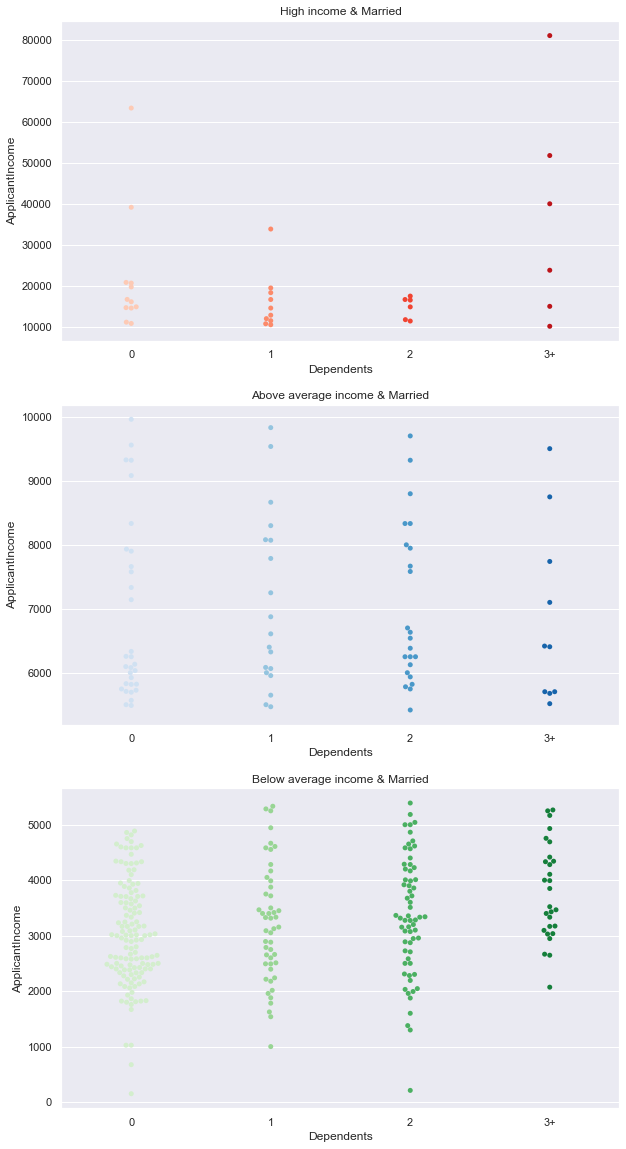

In [28]:
sns.set(rc={'figure.figsize':(10,20)})

subplot(3,1,1)
plt.title('High income & Married')
f1 = sns.swarmplot(data=high_income[high_income.Married=='Yes'], x='Dependents', y='ApplicantIncome', palette='Reds', order=['0','1','2','3+'])

subplot(3,1,2)
plt.title('Above average income & Married')
f2 = sns.swarmplot(data=above_average_income[above_average_income.Married=='Yes'], x='Dependents', y='ApplicantIncome', palette='Blues', order=['0','1','2','3+'])

subplot(3,1,3)
plt.title('Below average income & Married')
f3 = sns.swarmplot(data=below_average_income[below_average_income.Married=='Yes'], x='Dependents', y='ApplicantIncome', palette='Greens', order=['0','1','2','3+'])

plt.show()

In [29]:
ntrain[ntrain.Dependents.isnull()].sort_values(by='ApplicantIncome', ascending=False)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
102,LP001350,Male,Yes,NaN,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
120,LP001426,Male,Yes,NaN,Graduate,No,5667,2667.0,180.0,360.0,1.0,Rural,Y
335,LP002106,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y
571,LP002847,Male,Yes,NaN,Graduate,No,5116,1451.0,165.0,360.0,0.0,Urban,N
228,LP001760,Male,Yes,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
226,LP001754,Male,Yes,NaN,Not Graduate,Yes,4735,0.0,138.0,360.0,1.0,Urban,N
104,LP001357,Male,Yes,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
346,LP002130,Male,Yes,NaN,Not Graduate,No,3523,3230.0,152.0,360.0,0.0,Rural,N
517,LP002682,Male,Yes,NaN,Not Graduate,No,3074,1800.0,123.0,360.0,0.0,Semiurban,N
301,LP001972,Male,Yes,NaN,Not Graduate,No,2875,1750.0,105.0,360.0,1.0,Semiurban,Y


In [30]:
ntrain.loc[ntrain.Dependents.isnull(), 'Dependents'] = '0'
ntrain[ntrain.Dependents.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Employment type

In [31]:
ntrain[ntrain.Self_Employed.isnull()].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840.0,109.0,360.0,1.0,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500.0,115.0,NaN,1.0,Urban,Y
24,LP001052,Male,Yes,1,Graduate,NaN,3717,2925.0,151.0,360.0,NaN,Semiurban,N
29,LP001087,Female,No,2,Graduate,NaN,3750,2083.0,120.0,360.0,1.0,Semiurban,Y
30,LP001091,Male,Yes,1,Graduate,NaN,4166,3369.0,201.0,360.0,NaN,Urban,N


In [32]:
ntrain.loc[ntrain.Self_Employed.isnull(), 'Self_Employed'] = 'No'
ntrain[ntrain.Self_Employed.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Loan Amount

In [33]:
ntrain[ntrain.LoanAmount.isnull()].sort_values(by='ApplicantIncome', ascending=False)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
284,LP001922,Male,Yes,0,Graduate,No,20667,0.0,NaN,360.0,1.0,Rural,N
102,LP001350,Male,Yes,0,Graduate,No,13650,0.0,NaN,360.0,1.0,Urban,Y
435,LP002393,Female,No,0,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y
113,LP001392,Female,No,1,Graduate,Yes,7451,0.0,NaN,360.0,1.0,Semiurban,Y
95,LP001326,Male,No,0,Graduate,No,6782,0.0,NaN,360.0,NaN,Urban,N
550,LP002778,Male,Yes,2,Graduate,Yes,6633,0.0,NaN,360.0,0.0,Rural,N
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
63,LP001213,Male,Yes,1,Graduate,No,4945,0.0,NaN,360.0,0.0,Rural,N
524,LP002697,Male,No,0,Graduate,No,4680,2087.0,NaN,360.0,1.0,Semiurban,N
103,LP001356,Male,Yes,0,Graduate,No,4652,3583.0,NaN,360.0,1.0,Semiurban,Y


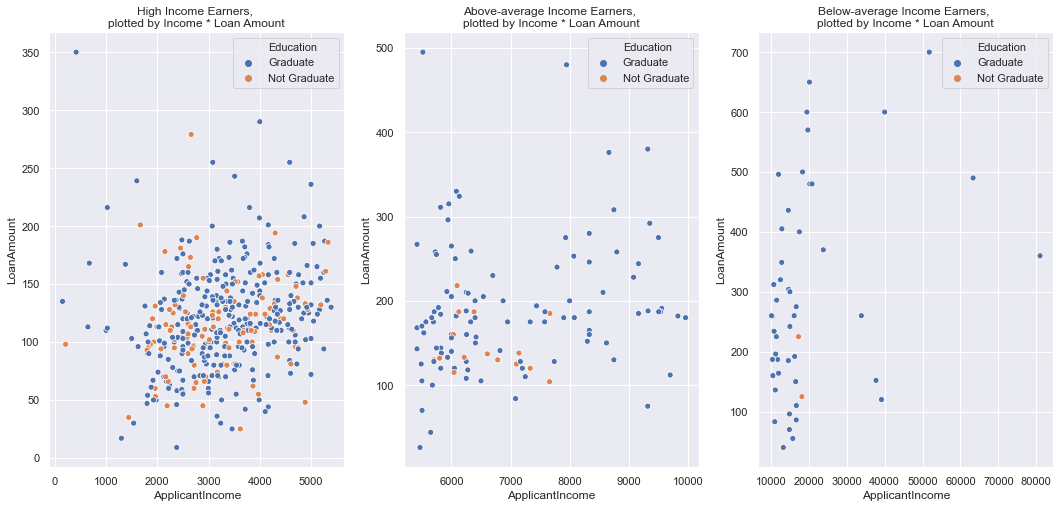

In [34]:
sns.set(rc={'figure.figsize':(18,8)})

subplot(1,3,1)
plt.title("High Income Earners, \nplotted by Income * Loan Amount")
f1 = sns.scatterplot(data=below_average_income, x='ApplicantIncome', y='LoanAmount', hue='Education')

subplot(1,3,2)
plt.title("Above-average Income Earners, \nplotted by Income * Loan Amount")
f2 = sns.scatterplot(data=above_average_income, x='ApplicantIncome', y='LoanAmount', hue='Education')

subplot(1,3,3)
plt.title("Below-average Income Earners, \nplotted by Income * Loan Amount")
f3 = sns.scatterplot(data=high_income, x='ApplicantIncome', y='LoanAmount', hue='Education')

plt.show()

Below average Loan Amount mean value: 118.46
Above average Loan Amount mean value: 186.58
High income Loan Amount mean value: 288.61


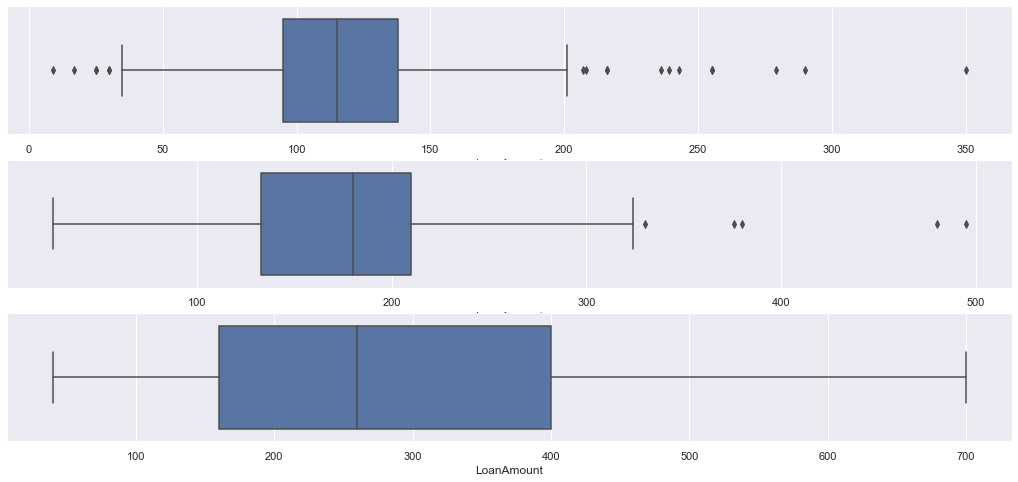

In [35]:
sns.set(rc={'figure.figsize':(18,8)})

subplot(3,1,1)
f1 = sns.boxplot(data=below_average_income, x='LoanAmount')
print(f"Below average Loan Amount mean value: {below_average_income.LoanAmount.mean():.2f}")

subplot(3,1,2)
f2 = sns.boxplot(data=above_average_income, x='LoanAmount')
print(f"Above average Loan Amount mean value: {above_average_income.LoanAmount.mean():.2f}")

subplot(3,1,3)
f3 = sns.boxplot(data=high_income, x='LoanAmount')
print(f"High income Loan Amount mean value: {high_income.LoanAmount.mean():.2f}")

plt.show()

In [36]:
ntrain.loc[(ntrain.LoanAmount.isnull())&(ntrain.ApplicantIncome>10000),"LoanAmount"] = round(high_income.LoanAmount.mean())
ntrain.loc[(ntrain.LoanAmount.isnull())&(ntrain.ApplicantIncome>ntrain.ApplicantIncome.mean()),"LoanAmount"] = round(above_average_income.LoanAmount.mean())
ntrain.loc[ntrain.LoanAmount.isnull(),"LoanAmount"] = round(below_average_income.LoanAmount.mean())

ntrain[ntrain.LoanAmount.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Loan Amount Term

In [37]:
ntrain[ntrain.Loan_Amount_Term.isnull()].sort_values(by='LoanAmount', ascending=False)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
165,LP001574,Male,Yes,0,Graduate,No,3707,3166.0,182.0,NaN,1.0,Rural,Y
223,LP001749,Male,Yes,0,Graduate,No,7578,1010.0,175.0,NaN,1.0,Semiurban,Y
112,LP001391,Male,Yes,0,Not Graduate,No,3572,4114.0,152.0,NaN,0.0,Rural,N
367,LP002188,Male,No,0,Graduate,No,5124,0.0,124.0,NaN,0.0,Rural,N
197,LP001669,Female,No,0,Not Graduate,No,1907,2365.0,120.0,NaN,1.0,Urban,Y
232,LP001770,Male,No,0,Not Graduate,No,3189,2598.0,120.0,NaN,1.0,Rural,Y
19,LP001041,Male,Yes,0,Graduate,No,2600,3500.0,115.0,NaN,1.0,Urban,Y
423,LP002362,Male,Yes,1,Graduate,No,7250,1667.0,110.0,NaN,0.0,Urban,N
36,LP001109,Male,Yes,0,Graduate,No,1828,1330.0,100.0,NaN,0.0,Urban,N
44,LP001136,Male,Yes,0,Not Graduate,Yes,4695,0.0,96.0,NaN,1.0,Urban,Y


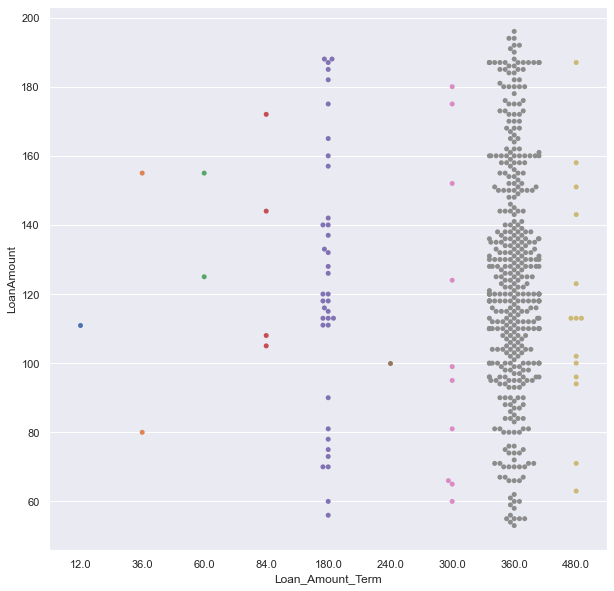

In [38]:
plt.figure(figsize=(10,10))
sns.swarmplot(data=ntrain[(ntrain.LoanAmount>50)&(ntrain.LoanAmount<200)], x='Loan_Amount_Term', y='LoanAmount')

In [39]:
ntrain.loc[ntrain.Loan_Amount_Term.isnull(), 'Loan_Amount_Term'] = '360.0'
ntrain[ntrain.Loan_Amount_Term.isnull()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status


### Credit History

In [40]:
ntrain[ntrain.Credit_History.isnull()].head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
16,LP001034,Male,No,1,Not Graduate,No,3596,0.0,100.0,240,NaN,Urban,Y
24,LP001052,Male,Yes,1,Graduate,No,3717,2925.0,151.0,360,NaN,Semiurban,N
30,LP001091,Male,Yes,1,Graduate,No,4166,3369.0,201.0,360,NaN,Urban,N
42,LP001123,Male,Yes,0,Graduate,No,2400,0.0,75.0,360,NaN,Urban,Y
79,LP001264,Male,Yes,3+,Not Graduate,Yes,3333,2166.0,130.0,360,NaN,Semiurban,Y


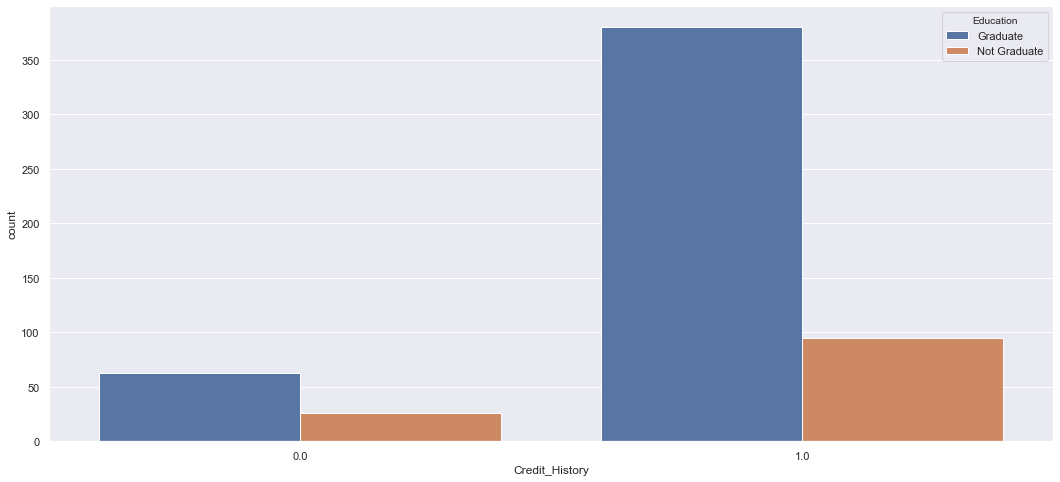

In [41]:
sns.countplot(data=ntrain, x='Credit_History', hue='Education')

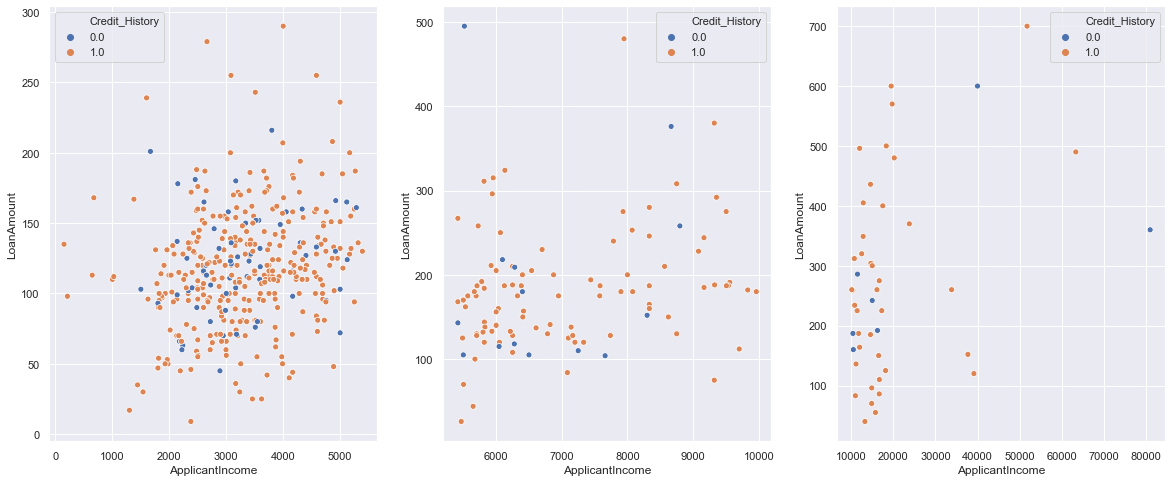

In [53]:
sns.set(rc={'figure.figsize':(20,8)})

subplot(1,3,1)
f1 = sns.scatterplot(data=below_average_income, x='ApplicantIncome', y='LoanAmount', hue='Credit_History')

subplot(1,3,2)
f2 = sns.scatterplot(data=above_average_income, x='ApplicantIncome', y='LoanAmount', hue='Credit_History')

subplot(1,3,3)
f3 = sns.scatterplot(data=high_income, x='ApplicantIncome', y='LoanAmount', hue='Credit_History')

plt.show()

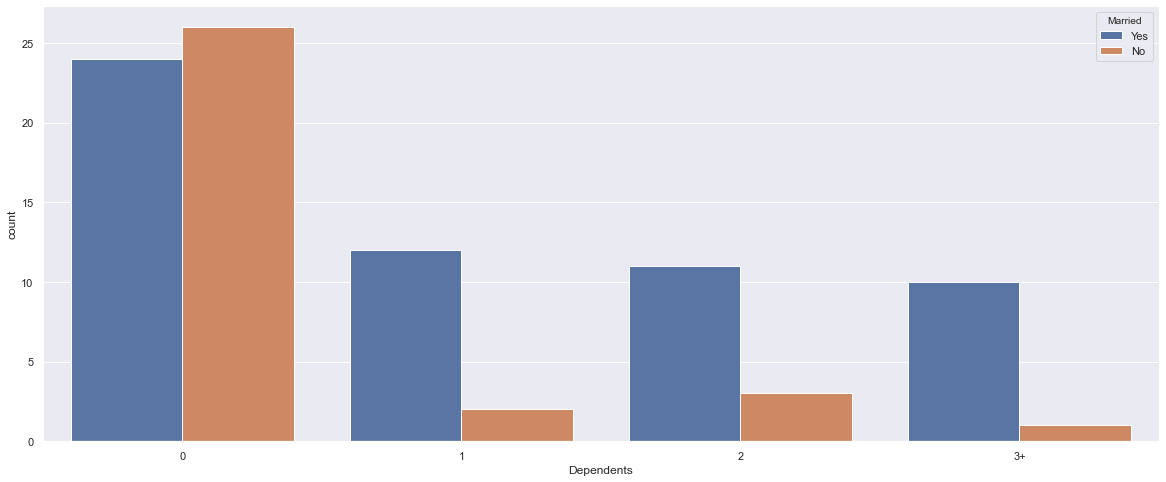

In [61]:
sns.countplot(data=ntrain[ntrain.Credit_History==0], x='Dependents',hue='Married', order=['0','1','2','3+'])

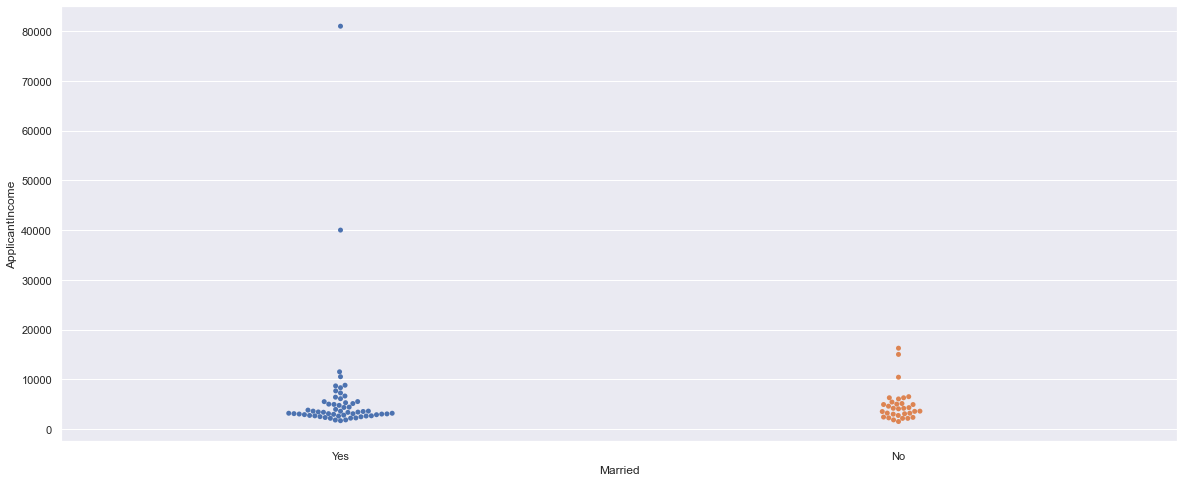

In [65]:
sns.swarmplot(data=ntrain[ntrain.Credit_History==0], y='ApplicantIncome',x='Married')

In [ ]:
females = ntrain[ntrain.Gender=='Female']
males = ntrain[ntrain.Gender=='Male']

### Marriage status and Income, by gender

In [ ]:
print("Female applicants' Income, by their marriage status")
print(f"The average income for all female applicants is: {ntrain[ntrain.Gender=='Female'].ApplicantIncome.mean():.2f}")
income_by_marriage_female = pd.pivot_table(females, index='Married', values='ApplicantIncome')
income_by_marriage_female

In [ ]:
print("Male applicants' Income, by their marriage status")
print(f"The average income for all male applicants is: {ntrain[ntrain.Gender=='Male'].ApplicantIncome.mean():.2f}")
income_by_marriage_male = pd.pivot_table(males, index='Married', values='ApplicantIncome')
income_by_marriage_male

In [ ]:
print(f"Married female applicants earn {(income_by_marriage_female.iloc[1][0]/income_by_marriage_female.iloc[0][0])*100:.2f}% more than their unmarried counterparts")
print(f"Married male applicants earn {(income_by_marriage_male.iloc[1][0]/income_by_marriage_male.iloc[0][0])*100:.2f}% more than their unmarried counterparts")

In [ ]:
pd.pivot_table(females, index=['Married','Education'], values=['ApplicantIncome', 'CoapplicantIncome'])

1. The highest earning group of female applicants is married females with an education level of graduate (or higher).
2. Unmarried female applicants with a lower education status has the lowest income but the highest co-applicant income.
3. Surprisingly, if not married, non-graduate applicants earn more than graduate applicants.

In [ ]:
pd.pivot_table(males, index=['Married','Education'], values=['ApplicantIncome', 'CoapplicantIncome'])

In [ ]:
sns.countplot(data=females, x='Married', hue='Education')

In [ ]:
males.describe()

In [ ]:
# How does the level of education affect an applicant's Income bracket 
# (as well as the income bracket of their coapplicant)
print(pd.pivot_table(ntrain, index='Education', values='ApplicantIncome'))
print('\n')
print(pd.pivot_table(ntrain, index='Education', values='CoapplicantIncome'))

In [ ]:
# The 'Dependents' column
sns.set(rc={'figure.figsize': (14,20)})

subplot(3,1,1)
plt.title("Number of dependents & Marriage status")
f1 = sns.countplot(data=ntrain, x='Dependents', hue='Married')

subplot(3,1,2)
plt.title("Number of dependents & Education level")
f2 = sns.countplot(data=ntrain, x='Dependents', hue='Education')

subplot(3,1,3)
plt.title("Number of dependents & Applicant Income")
f3 = sns.swarmplot(data=ntrain, x='Dependents', y='ApplicantIncome')

plt.show()

In [ ]:
# The 'Self_Employed' column

In [ ]:
# The 'LoanAmount' and 'Loan_Amount_Term' columns

In [ ]:
# The 'Credit_History' column

In [ ]:
ntrain.loc[ntrain.Dependents.isnull(), 'Dependents'] = '0'
ntrain[ntrain.Dependents.isnull()]

In [ ]:
# Creating a copy of the original dataset
ntrain = train.copy()

# Binary Encoding the following columns:
# (Generally 0 means 'no' or implies negation, while 1 the opposite)

# Gender
ntrain.loc[ntrain.Gender == 'Male', 'Gender_encoded'] = 0
ntrain.loc[ntrain.Gender == 'Female', 'Gender_encoded'] = 1
print(ntrain.shape)

# Married
ntrain.loc[ntrain.Married == 'No', 'is_married'] = 0
ntrain.loc[ntrain.Married == 'Yes', 'is_married'] = 1
print(ntrain.shape)

# Married
ntrain.loc[ntrain.Education == 'No', 'is_graduate'] = 0
ntrain.loc[ntrain.Education == 'Yes', 'is_graduate'] = 1
print(ntrain.shape)

# Self_Employed
ntrain.loc[ntrain.Self_Employed == 'No', 'is_self_employed'] = 0
ntrain.loc[ntrain.Self_Employed == 'Yes', 'is_self_employed'] = 1
print(ntrain.shape)

# Loan_Status
ntrain.loc[ntrain.Loan_Status == 'N', 'loan_approved'] = 0
ntrain.loc[ntrain.Loan_Status == 'Y', 'loan_approved'] = 1
print(ntrain.shape)

ntrain.head()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
binarizer = LabelBinarizer()

# Creat a new column called 'has_child'
ntrain.loc[ntrain.Dependents=='0', 'has_child'] = 0
ntrain.loc[ntrain.has_child.isnull(), 'has_child'] = 1

# Dependents
ntrain.Dependents = ntrain.Dependents.astype(str)
results = binarizer.fit_transform(ntrain["Dependents"])
dependents_encoded = pd.DataFrame(results, columns=['0','1','2','3','nan'])

# Property_Area
results = binarizer.fit_transform(ntrain["Property_Area"])
property_area_encoded = pd.DataFrame(results, columns=binarizer.classes_)

ntrain = pd.concat([ntrain, education_encoded, property_area_encoded, dependents_encoded], axis=1, sort=False)
ntrain.drop('Property_Area', axis=1, inplace=True)
ntrain.drop('Dependents', axis=1, inplace=True)

ntrain.head()

# Finding correlation between columns

In [ ]:
train.head()

In [ ]:
sns.

In [ ]:
plt.figure(figsize=(10,8))
sns.countplot(data=train, x='Married', hue='Gender')

In [ ]:
train[train.Gender.isnull()]

In [ ]:
sns.countplot(data=train, x='Self_Employed', hue='Gender')

In [ ]:
sns.pairplot(train, hue='Gender', height=2.5)

# Preprocessing Data (2)